#Input-Output Handling & Storage (Unable to run a full Docker container as Colab)

In [1]:
!pip install pandas

In [2]:
import pandas as pd

# Sample data (manually added for now)
cargo_data = [
    {"Item_ID": "001", "Name": "Food Packet", "Width": 10, "Depth": 10, "Height": 20, "Mass": 5, "Priority": 80, "Expiry_Date": "2025-05-20", "Usage_Limit": 30, "Preferred_Zone": "Crew Quarters"},
    {"Item_ID": "002", "Name": "Oxygen Cylinder", "Width": 15, "Depth": 15, "Height": 50, "Mass": 30, "Priority": 95, "Expiry_Date": None, "Usage_Limit": 100, "Preferred_Zone": "Airlock"},
    {"Item_ID": "003", "Name": "First Aid Kit", "Width": 20, "Depth": 20, "Height": 10, "Mass": 2, "Priority": 100, "Expiry_Date": "2025-07-10", "Usage_Limit": 5, "Preferred_Zone": "Medical Bay"},
]

# Convert to Pandas DataFrame
cargo_df = pd.DataFrame(cargo_data)

# Display the initial cargo
print("Initial Cargo Data:")
print(cargo_df)


Initial Cargo Data:
  Item_ID             Name  Width  Depth  Height  Mass  Priority Expiry_Date  \
0     001      Food Packet     10     10      20     5        80  2025-05-20   
1     002  Oxygen Cylinder     15     15      50    30        95        None   
2     003    First Aid Kit     20     20      10     2       100  2025-07-10   

   Usage_Limit Preferred_Zone  
0           30  Crew Quarters  
1          100        Airlock  
2            5    Medical Bay  


In [3]:
# Function to add an item
def add_item(item_data):
    global cargo_df
    new_item_df = pd.DataFrame([item_data])  # Convert dictionary to DataFrame
    cargo_df = pd.concat([cargo_df, new_item_df], ignore_index=True)  # Use concat instead of append
    print(f"Added item: {item_data['Name']}")

# Function to remove an item
def remove_item(item_id):
    global cargo_df
    cargo_df = cargo_df[cargo_df["Item_ID"] != item_id]
    print(f" Removed item with ID: {item_id}")

# Example usage:
new_item = {"Item_ID": "004", "Name": "Battery Pack", "Width": 5, "Depth": 5, "Height": 10, "Mass": 1, "Priority": 50, "Expiry_Date": None, "Usage_Limit": 20, "Preferred_Zone": "Engineering Bay"}
add_item(new_item)

remove_item("002")

# Display updated cargo
print("\nUpdated Cargo Data:")
print(cargo_df)

Added item: Battery Pack
 Removed item with ID: 002

Updated Cargo Data:
  Item_ID           Name  Width  Depth  Height  Mass  Priority Expiry_Date  \
0     001    Food Packet     10     10      20     5        80  2025-05-20   
2     003  First Aid Kit     20     20      10     2       100  2025-07-10   
3     004   Battery Pack      5      5      10     1        50        None   

   Usage_Limit   Preferred_Zone  
0           30    Crew Quarters  
2            5      Medical Bay  
3           20  Engineering Bay  


In [4]:
import pandas as pd

# Defining storage zones with volume constraints (Width, Depth, Height)
storage_zones = {
    "Crew Quarters": {"Width": 100, "Depth": 100, "Height": 200, "Occupied": []},
    "Airlock": {"Width": 80, "Depth": 80, "Height": 180, "Occupied": []},
    "Medical Bay": {"Width": 50, "Depth": 50, "Height": 100, "Occupied": []},
    "Engineering Bay": {"Width": 120, "Depth": 120, "Height": 250, "Occupied": []}
}

# Function to calculate available space in a zone
def available_space(zone):
    total_volume = zone["Width"] * zone["Depth"] * zone["Height"]
    occupied_volume = sum(item["Width"] * item["Depth"] * item["Height"] for item in zone["Occupied"])
    return total_volume - occupied_volume

# Function to suggest a placement for an item
def suggest_placement(item):
    preferred_zone = item["Preferred_Zone"]

    # Try placing in the preferred zone
    if available_space(storage_zones[preferred_zone]) >= (item["Width"] * item["Depth"] * item["Height"]):
        storage_zones[preferred_zone]["Occupied"].append(item)
        return f"Placed '{item['Name']}' in {preferred_zone}."

    # Try rearranging lower-priority items
    for zone_name, zone in storage_zones.items():
        if zone_name != preferred_zone:
            lower_priority_items = sorted(zone["Occupied"], key=lambda x: x["Priority"])
            for low_item in lower_priority_items:
                if low_item["Priority"] < item["Priority"] and available_space(zone) >= (item["Width"] * item["Depth"] * item["Height"]):
                    zone["Occupied"].remove(low_item)
                    storage_zones[preferred_zone]["Occupied"].append(item)
                    return f" Rearranged '{low_item['Name']}' to make space for '{item['Name']}' in {preferred_zone}."

    return f" No space in {preferred_zone}. Consider alternative storage."

# Example item
test_item = {"Item_ID": "005", "Name": "Medical Kit", "Width": 20, "Depth": 20, "Height": 10, "Mass": 2, "Priority": 100, "Expiry_Date": "2025-12-01", "Usage_Limit": 10, "Preferred_Zone": "Medical Bay"}

# Run the placement suggestion
print(suggest_placement(test_item))


Placed 'Medical Kit' in Medical Bay.


Item 001 placed in Crew Quarters at (0, 0, 0)
Item 002 placed in Crew Quarters at (0, 0, 20)
Item 003 placed in Crew Quarters at (0, 0, 70)


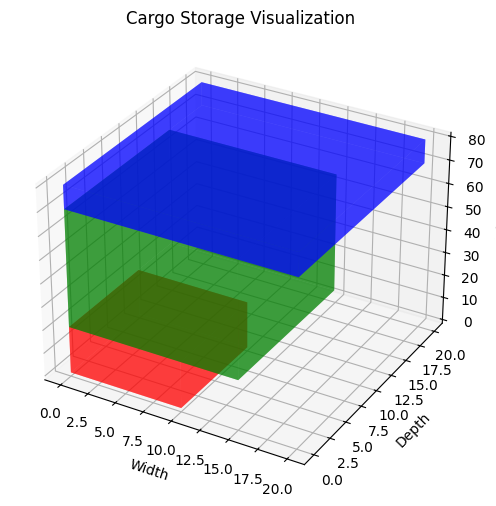

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class CargoStorage:
    def __init__(self, containers):
        self.containers = containers  # Dictionary with container details
        self.items = []  # List of stored items
        self.occupied_spaces = {container_id: np.zeros((container['Width'], container['Depth'], container['Height'])) for container_id, container in containers.items()}

    def add_item(self, item):
        for container_id, container in self.containers.items():
            if self._fits_in_container(item, container):
                position = self._find_best_position(item, container_id)
                if position:
                    self._store_item(item, container_id, position)
                    return f"Item {item['Item ID']} placed in {container_id} at {position}"

        self._rearrange_storage()
        return self.add_item(item)  # Try again after rearrangement

    def _fits_in_container(self, item, container):
        return (
            item['Width'] <= container['Width'] and
            item['Depth'] <= container['Depth'] and
            item['Height'] <= container['Height']
        )

    def _find_best_position(self, item, container_id):
        occupied = self.occupied_spaces[container_id]
        for w in range(self.containers[container_id]['Width'] - item['Width'] + 1):
            for d in range(self.containers[container_id]['Depth'] - item['Depth'] + 1):
                for h in range(self.containers[container_id]['Height'] - item['Height'] + 1):
                    if np.sum(occupied[w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']]) == 0:
                        return (w, d, h)
        return None

    def _store_item(self, item, container_id, position):
        item['Container'] = container_id
        item['Position'] = position
        self.items.append(item)
        w, d, h = position
        self.occupied_spaces[container_id][w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']] = 1

    def _rearrange_storage(self):
        self.items.sort(key=lambda x: x['Priority'], reverse=True)
        stored_items = self.items.copy()
        self.items.clear()
        self.occupied_spaces = {container_id: np.zeros((container['Width'], container['Depth'], container['Height'])) for container_id, container in self.containers.items()}
        for item in stored_items:
            self.add_item(item)  # Re-add items to optimize space usage

    def plot_storage(self):
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111, projection='3d')

        colors = ['r', 'g', 'b', 'y', 'c', 'm']
        color_idx = 0

        for item in self.items:
            w, d, h = item['Position']
            width, depth, height = item['Width'], item['Depth'], item['Height']
            color = colors[color_idx % len(colors)]
            color_idx += 1

            verts = [
                [(w, d, h), (w + width, d, h), (w + width, d + depth, h), (w, d + depth, h)],
                [(w, d, h + height), (w + width, d, h + height), (w + width, d + depth, h + height), (w, d + depth, h + height)],
                [(w, d, h), (w, d, h + height), (w, d + depth, h + height), (w, d + depth, h)],
                [(w + width, d, h), (w + width, d, h + height), (w + width, d + depth, h + height), (w + width, d + depth, h)],
                [(w, d, h), (w + width, d, h), (w + width, d, h + height), (w, d, h + height)],
                [(w, d + depth, h), (w + width, d + depth, h), (w + width, d + depth, h + height), (w, d + depth, h + height)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, alpha=0.5, facecolor=color))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        ax.set_title('Cargo Storage Visualization')
        plt.show()

# Example test data
containers = {
    'Crew Quarters': {'ID': 'contA', 'Width': 100, 'Depth': 85, 'Height': 200},
    'Airlock': {'ID': 'contB', 'Width': 50, 'Depth': 85, 'Height': 200},
    'Laboratory': {'ID': 'contC', 'Width': 200, 'Depth': 85, 'Height': 200},
}

items = [
    {'Item ID': '001', 'Name': 'Food Packet', 'Width': 10, 'Depth': 10, 'Height': 20, 'Mass': 5, 'Priority': 80},
    {'Item ID': '002', 'Name': 'Oxygen Cylinder', 'Width': 15, 'Depth': 15, 'Height': 50, 'Mass': 30, 'Priority': 95},
    {'Item ID': '003', 'Name': 'First Aid Kit', 'Width': 20, 'Depth': 20, 'Height': 10, 'Mass': 2, 'Priority': 100}
]

storage = CargoStorage(containers)
for item in items:
    print(storage.add_item(item))

storage.plot_storage()

Item 001 placed in Crew Quarters at (0, 0, 0)
Item 002 placed in Crew Quarters at (0, 0, 10)
Item 003 placed in Crew Quarters at (0, 0, 25)


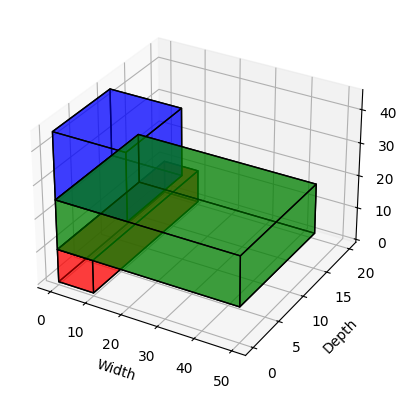

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import permutations

class CargoStorage:
    def __init__(self, containers):
        self.containers = containers  # Dictionary with container details
        self.items = []  # List of stored items
        self.occupied_spaces = {container_id: np.zeros((container['Width'], container['Depth'], container['Height'])) for container_id, container in containers.items()}

    def add_item(self, item):
        for container_id, container in self.containers.items():
            for rotated_item in self._generate_rotations(item):
                position = self._find_best_position(rotated_item, container_id)
                if position:
                    self._store_item(rotated_item, container_id, position)
                    return f"Item {item['Item ID']} placed in {container_id} at {position}"

        self._rearrange_storage()
        return self.add_item(item)  # Try again after rearrangement

    def _generate_rotations(self, item):
        dimensions = [(item['Width'], item['Depth'], item['Height'])]
        return [dict(item, Width=w, Depth=d, Height=h) for w, d, h in set(permutations(dimensions[0]))]

    def _find_best_position(self, item, container_id):
        occupied = self.occupied_spaces[container_id]
        for w in range(self.containers[container_id]['Width'] - item['Width'] + 1):
            for d in range(self.containers[container_id]['Depth'] - item['Depth'] + 1):
                for h in range(self.containers[container_id]['Height'] - item['Height'] + 1):
                    if np.sum(occupied[w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']]) == 0:
                        return (w, d, h)
        return None

    def _store_item(self, item, container_id, position):
        item['Container'] = container_id
        item['Position'] = position
        self.items.append(item)
        w, d, h = position
        self.occupied_spaces[container_id][w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']] = 1

    def _rearrange_storage(self):
        self.items.sort(key=lambda x: x['Priority'], reverse=True)
        stored_items = self.items.copy()
        self.items.clear()
        self.occupied_spaces = {container_id: np.zeros((container['Width'], container['Depth'], container['Height'])) for container_id, container in self.containers.items()}
        for item in stored_items:
            self.add_item(item)  # Re-add items to optimize space usage

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']
        color_idx = 0

        for item in self.items:
            w, d, h = item['Position']
            x_size, y_size, z_size = item['Width'], item['Depth'], item['Height']
            color = colors[color_idx % len(colors)]
            color_idx += 1

            verts = [
                [(w, d, h), (w + x_size, d, h), (w + x_size, d + y_size, h), (w, d + y_size, h)],
                [(w, d, h + z_size), (w + x_size, d, h + z_size), (w + x_size, d + y_size, h + z_size), (w, d + y_size, h + z_size)],
                [(w, d, h), (w, d, h + z_size), (w, d + y_size, h + z_size), (w, d + y_size, h)],
                [(w + x_size, d, h), (w + x_size, d, h + z_size), (w + x_size, d + y_size, h + z_size), (w + x_size, d + y_size, h)],
                [(w, d, h), (w + x_size, d, h), (w + x_size, d, h + z_size), (w, d, h + z_size)],
                [(w, d + y_size, h), (w + x_size, d + y_size, h), (w + x_size, d + y_size, h + z_size), (w, d + y_size, h + z_size)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

# Example test data
containers = {
    'Crew Quarters': {'ID': 'contA', 'Width': 100, 'Depth': 85, 'Height': 200},
    'Airlock': {'ID': 'contB', 'Width': 50, 'Depth': 85, 'Height': 200},
    'Laboratory': {'ID': 'contC', 'Width': 200, 'Depth': 85, 'Height': 200},
}

items = [
    {'Item ID': '001', 'Name': 'Food Packet', 'Width': 10, 'Depth': 10, 'Height': 20, 'Mass': 5, 'Priority': 80},
    {'Item ID': '002', 'Name': 'Oxygen Cylinder', 'Width': 15, 'Depth': 15, 'Height': 50, 'Mass': 30, 'Priority': 95},
    {'Item ID': '003', 'Name': 'First Aid Kit', 'Width': 20, 'Depth': 20, 'Height': 10, 'Mass': 2, 'Priority': 100}
]

storage = CargoStorage(containers)
for item in items:
    print(storage.add_item(item))

storage.plot_storage()

Item 001 placed in Crew Quarters at (0, 0, 0)
Item 002 placed in Crew Quarters at (0, 0, 20)
Item 003 placed in Crew Quarters at (0, 0, 36)
Item 004 placed in Crew Quarters at (0, 0, 41)
Item 005 placed in Crew Quarters at (0, 0, 48)
Item 006 placed in Crew Quarters at (0, 0, 53)
Item 007 placed in Crew Quarters at (0, 0, 58)
Item 008 placed in Crew Quarters at (0, 0, 65)
Item 009 placed in Crew Quarters at (0, 0, 79)
Item 010 placed in Crew Quarters at (0, 0, 97)
Item 011 placed in Crew Quarters at (0, 0, 117)
Item 012 placed in Crew Quarters at (0, 0, 132)
Item 013 placed in Crew Quarters at (0, 0, 148)
Item 014 placed in Crew Quarters at (0, 0, 163)
Item 015 placed in Crew Quarters at (0, 0, 168)
Item 016 placed in Crew Quarters at (0, 0, 181)
Item 017 placed in Crew Quarters at (0, 5, 79)
Item 018 placed in Crew Quarters at (0, 8, 84)
Item 019 placed in Crew Quarters at (0, 8, 20)
Item 020 placed in Crew Quarters at (0, 8, 48)
Item 021 placed in Crew Quarters at (0, 10, 103)
Item 0

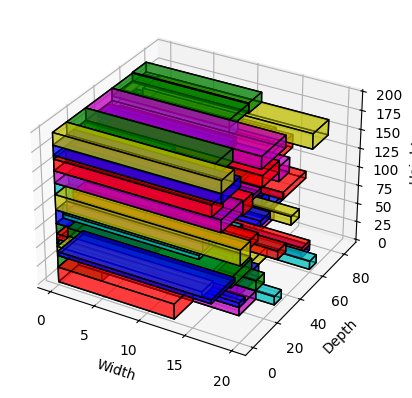

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import permutations
import random

class CargoStorage:
    def __init__(self, containers):
        self.containers = containers  # Dictionary with container details
        self.items = []  # List of stored items
        self.occupied_spaces = {container_id: np.zeros((container['Width'], container['Depth'], container['Height'])) for container_id, container in containers.items()}

    def add_item(self, item):
        for container_id, container in self.containers.items():
            for rotated_item in self._generate_rotations(item):
                position = self._find_best_position(rotated_item, container_id)
                if position:
                    self._store_item(rotated_item, container_id, position)
                    return f"Item {item['Item ID']} placed in {container_id} at {position}"

        self._rearrange_storage()
        return self.add_item(item)  # Try again after rearrangement

    def _generate_rotations(self, item):
        dimensions = [(item['Width'], item['Depth'], item['Height'])]
        return [dict(item, Width=w, Depth=d, Height=h) for w, d, h in set(permutations(dimensions[0]))]

    def _find_best_position(self, item, container_id):
        occupied = self.occupied_spaces[container_id]
        for w in range(self.containers[container_id]['Width'] - item['Width'] + 1):
            for d in range(self.containers[container_id]['Depth'] - item['Depth'] + 1):
                for h in range(self.containers[container_id]['Height'] - item['Height'] + 1):
                    if np.sum(occupied[w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']]) == 0:
                        return (w, d, h)
        return None

    def _store_item(self, item, container_id, position):
        item['Container'] = container_id
        item['Position'] = position
        self.items.append(item)
        w, d, h = position
        self.occupied_spaces[container_id][w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']] = 1

    def _rearrange_storage(self):
        self.items.sort(key=lambda x: x['Priority'], reverse=True)
        stored_items = self.items.copy()
        self.items.clear()
        self.occupied_spaces = {container_id: np.zeros((container['Width'], container['Depth'], container['Height'])) for container_id, container in self.containers.items()}
        for item in stored_items:
            self.add_item(item)  # Re-add items to optimize space usage

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']
        color_idx = 0

        for item in self.items:
            w, d, h = item['Position']
            x_size, y_size, z_size = item['Width'], item['Depth'], item['Height']
            color = colors[color_idx % len(colors)]
            color_idx += 1

            verts = [
                [(w, d, h), (w + x_size, d, h), (w + x_size, d + y_size, h), (w, d + y_size, h)],
                [(w, d, h + z_size), (w + x_size, d, h + z_size), (w + x_size, d + y_size, h + z_size), (w, d + y_size, h + z_size)],
                [(w, d, h), (w, d, h + z_size), (w, d + y_size, h + z_size), (w, d + y_size, h)],
                [(w + x_size, d, h), (w + x_size, d, h + z_size), (w + x_size, d + y_size, h + z_size), (w + x_size, d + y_size, h)],
                [(w, d, h), (w + x_size, d, h), (w + x_size, d, h + z_size), (w, d, h + z_size)],
                [(w, d + y_size, h), (w + x_size, d + y_size, h), (w + x_size, d + y_size, h + z_size), (w, d + y_size, h + z_size)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

# Example test data
containers = {
    'Crew Quarters': {'ID': 'contA', 'Width': 100, 'Depth': 85, 'Height': 200},
    'Airlock': {'ID': 'contB', 'Width': 50, 'Depth': 85, 'Height': 200},
    'Laboratory': {'ID': 'contC', 'Width': 200, 'Depth': 85, 'Height': 200},
}

# Generate 100 random items
items = [
    {'Item ID': str(i).zfill(3), 'Name': f'Item {i}', 'Width': random.randint(5, 20), 'Depth': random.randint(5, 20), 'Height': random.randint(5, 20), 'Mass': random.randint(1, 50), 'Priority': random.randint(50, 100)}
    for i in range(1, 101)
]

storage = CargoStorage(containers)
for item in items:
    print(storage.add_item(item))

storage.plot_storage()

Item 001 placed in Crew Quarters from (0, 0, 0) to (18, 10, 11)
Item 002 placed in Crew Quarters from (0, 0, 12) to (10, 14, 27)
Item 003 placed in Crew Quarters from (0, 0, 28) to (11, 19, 40)
Item 004 placed in Crew Quarters from (0, 0, 41) to (11, 19, 53)
Item 005 placed in Crew Quarters from (0, 0, 54) to (15, 19, 71)
Item 006 placed in Crew Quarters from (0, 0, 72) to (15, 8, 85)
Item 007 placed in Crew Quarters from (0, 0, 86) to (9, 10, 94)
Item 008 placed in Crew Quarters from (0, 0, 95) to (12, 5, 102)
Item 009 placed in Crew Quarters from (0, 0, 103) to (11, 11, 121)
Item 010 placed in Crew Quarters from (0, 0, 122) to (10, 16, 126)
Item 011 placed in Crew Quarters from (0, 0, 127) to (7, 5, 145)
Item 012 placed in Crew Quarters from (0, 0, 146) to (16, 13, 160)
Item 013 placed in Crew Quarters from (0, 0, 161) to (13, 11, 178)
Item 014 placed in Crew Quarters from (0, 0, 179) to (7, 10, 192)
Item 015 placed in Crew Quarters from (0, 6, 127) to (17, 18, 145)
Item 016 placed i

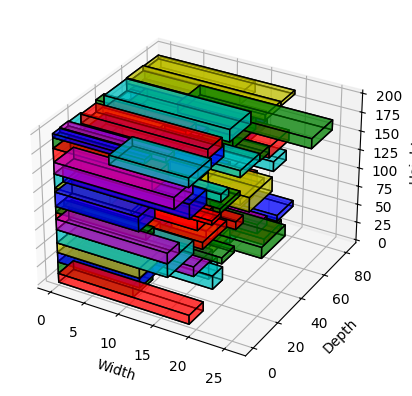

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import permutations
import random

class CargoStorage:
    def __init__(self, containers):
        self.containers = containers  # Dictionary with container details
        self.items = []  # List of stored items
        self.occupied_spaces = {container_id: np.zeros((container['Width'], container['Depth'], container['Height'])) for container_id, container in containers.items()}

    def add_item(self, item):
        for container_id, container in self.containers.items():
            for rotated_item in self._generate_rotations(item):
                position = self._find_best_position(rotated_item, container_id)
                if position:
                    self._store_item(rotated_item, container_id, position)
                    start_pos = position
                    end_pos = (position[0] + rotated_item['Width'] - 1, position[1] + rotated_item['Depth'] - 1, position[2] + rotated_item['Height'] - 1)
                    return f"Item {item['Item ID']} placed in {container_id} from {start_pos} to {end_pos}"

        self._rearrange_storage()
        return self.add_item(item)  # Try again after rearrangement

    def _generate_rotations(self, item):
        dimensions = [(item['Width'], item['Depth'], item['Height'])]
        return [dict(item, Width=w, Depth=d, Height=h) for w, d, h in set(permutations(dimensions[0]))]

    def _find_best_position(self, item, container_id):
        occupied = self.occupied_spaces[container_id]
        for w in range(self.containers[container_id]['Width'] - item['Width'] + 1):
            for d in range(self.containers[container_id]['Depth'] - item['Depth'] + 1):
                for h in range(self.containers[container_id]['Height'] - item['Height'] + 1):
                    if np.sum(occupied[w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']]) == 0:
                        return (w, d, h)
        return None

    def _store_item(self, item, container_id, position):
        item['Container'] = container_id
        item['Position'] = position
        self.items.append(item)
        w, d, h = position
        self.occupied_spaces[container_id][w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']] = 1

    def _rearrange_storage(self):
        self.items.sort(key=lambda x: x['Priority'], reverse=True)
        stored_items = self.items.copy()
        self.items.clear()
        self.occupied_spaces = {container_id: np.zeros((container['Width'], container['Depth'], container['Height'])) for container_id, container in self.containers.items()}
        for item in stored_items:
            self.add_item(item)  # Re-add items to optimize space usage

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']
        color_idx = 0

        for item in self.items:
            w, d, h = item['Position']
            x_size, y_size, z_size = item['Width'], item['Depth'], item['Height']
            color = colors[color_idx % len(colors)]
            color_idx += 1

            verts = [
                [(w, d, h), (w + x_size, d, h), (w + x_size, d + y_size, h), (w, d + y_size, h)],
                [(w, d, h + z_size), (w + x_size, d, h + z_size), (w + x_size, d + y_size, h + z_size), (w, d + y_size, h + z_size)],
                [(w, d, h), (w, d, h + z_size), (w, d + y_size, h + z_size), (w, d + y_size, h)],
                [(w + x_size, d, h), (w + x_size, d, h + z_size), (w + x_size, d + y_size, h + z_size), (w + x_size, d + y_size, h)],
                [(w, d, h), (w + x_size, d, h), (w + x_size, d, h + z_size), (w, d, h + z_size)],
                [(w, d + y_size, h), (w + x_size, d + y_size, h), (w + x_size, d + y_size, h + z_size), (w, d + y_size, h + z_size)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

# Example test data
containers = {
    'Crew Quarters': {'ID': 'contA', 'Width': 100, 'Depth': 85, 'Height': 200},
    'Airlock': {'ID': 'contB', 'Width': 50, 'Depth': 85, 'Height': 200},
    'Laboratory': {'ID': 'contC', 'Width': 200, 'Depth': 85, 'Height': 200},
}

# Generate 100 random items
items = [
    {'Item ID': str(i).zfill(3), 'Name': f'Item {i}', 'Width': random.randint(5, 20), 'Depth': random.randint(5, 20), 'Height': random.randint(5, 20), 'Mass': random.randint(1, 50), 'Priority': random.randint(50, 100)}
    for i in range(1, 101)
]

storage = CargoStorage(containers)
for item in items:
    print(storage.add_item(item))

storage.plot_storage()


Item 0001 placed from (0, 0, 0) to (5, 1, 8)
Item 0002 placed from (0, 0, 9) to (1, 1, 12)
Item 0003 placed from (0, 0, 13) to (5, 1, 14)
Item 0004 placed from (0, 0, 15) to (5, 3, 18)
Item 0005 placed from (0, 0, 19) to (3, 9, 27)
Item 0006 placed from (0, 0, 28) to (4, 6, 29)
Item 0007 placed from (0, 0, 30) to (9, 0, 31)
Item 0008 placed from (0, 0, 32) to (0, 7, 33)
Item 0009 placed from (0, 0, 34) to (4, 6, 35)
Item 0010 placed from (0, 0, 36) to (7, 7, 37)
Item 0011 placed from (0, 0, 38) to (6, 6, 40)
Item 0012 placed from (0, 0, 41) to (4, 7, 43)
Item 0013 placed from (0, 2, 0) to (5, 5, 9)
Item 0014 placed from (0, 0, 44) to (9, 6, 49)
Item 0015 placed from (0, 2, 10) to (4, 9, 12)
Item 0016 placed from (0, 6, 0) to (0, 11, 9)
Item 0017 placed from (0, 8, 28) to (7, 15, 35)
Item 0018 placed from (0, 4, 13) to (4, 10, 18)
Item 0019 placed from (0, 7, 38) to (2, 10, 40)
Item 0020 placed from (0, 7, 44) to (2, 14, 47)
Item 0021 placed from (0, 1, 30) to (9, 4, 30)
Item 0022 place

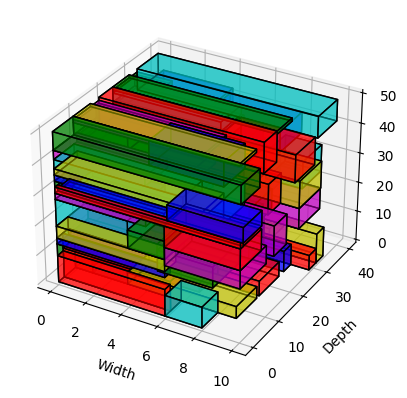

Remaining capacity (empty units): 6121


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import permutations
import random

class CargoStorage:
    def __init__(self, width=10, depth=40, height=50):
        self.width = width
        self.depth = depth
        self.height = height
        self.items = []  # List of stored items
        self.occupied_space = np.zeros((width, depth, height))

    def add_item(self, item):
        for rotated_item in self._generate_rotations(item):
            position = self._find_best_position(rotated_item)
            if position:
                self._store_item(rotated_item, position)
                start_pos = position
                end_pos = (position[0] + rotated_item['Width'] - 1, position[1] + rotated_item['Depth'] - 1, position[2] + rotated_item['Height'] - 1)
                return f"Item {item['Item ID']} placed from {start_pos} to {end_pos}"
        return f"No space for Item {item['Item ID']}"

    def _generate_rotations(self, item):
        dimensions = [(item['Width'], item['Depth'], item['Height'])]
        return [dict(item, Width=w, Depth=d, Height=h) for w, d, h in set(permutations(dimensions[0]))]

    def _find_best_position(self, item):
        for w in range(self.width - item['Width'] + 1):
            for d in range(self.depth - item['Depth'] + 1):
                for h in range(self.height - item['Height'] + 1):
                    if np.sum(self.occupied_space[w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']]) == 0:
                        return (w, d, h)
        return None

    def _store_item(self, item, position):
        item['Position'] = position
        self.items.append(item)
        w, d, h = position
        self.occupied_space[w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']] = 1

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']
        color_idx = 0

        for item in self.items:
            w, d, h = item['Position']
            x_size, y_size, z_size = item['Width'], item['Depth'], item['Height']
            color = colors[color_idx % len(colors)]
            color_idx += 1

            verts = [
                [(w, d, h), (w + x_size, d, h), (w + x_size, d + y_size, h), (w, d + y_size, h)],
                [(w, d, h + z_size), (w + x_size, d, h + z_size), (w + x_size, d + y_size, h + z_size), (w, d + y_size, h + z_size)],
                [(w, d, h), (w, d, h + z_size), (w, d + y_size, h + z_size), (w, d + y_size, h)],
                [(w + x_size, d, h), (w + x_size, d, h + z_size), (w + x_size, d + y_size, h + z_size), (w + x_size, d + y_size, h)],
                [(w, d, h), (w + x_size, d, h), (w + x_size, d, h + z_size), (w, d, h + z_size)],
                [(w, d + y_size, h), (w + x_size, d + y_size, h), (w + x_size, d + y_size, h + z_size), (w, d + y_size, h + z_size)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

# Generate 10,000 random items
items = [
    {'Item ID': str(i).zfill(4), 'Name': f'Item {i}', 'Width': random.randint(1, 10), 'Depth': random.randint(1, 10), 'Height': random.randint(1, 10), 'Mass': random.randint(1, 50), 'Priority': random.randint(50, 100)}
    for i in range(1, 101)
]

storage = CargoStorage()
for item in items:
    print(storage.add_item(item))

storage.plot_storage()

# Count remaining capacity
remaining_capacity = np.sum(storage.occupied_space == 0)
print(f"Remaining capacity (empty units): {remaining_capacity}")

Streaming output truncated to the last 5000 lines.
Item 5000 placed at (np.int64(0), np.int64(45), np.int64(68))
Item 5001 placed at (np.int64(74), np.int64(48), np.int64(42))
Item 5002 placed at (np.int64(75), np.int64(91), np.int64(0))
Item 5003 placed at (np.int64(98), np.int64(57), np.int64(84))
Item 5004 placed at (np.int64(89), np.int64(2), np.int64(93))
Item 5005 placed at (np.int64(49), np.int64(44), np.int64(87))
Item 5006 placed at (np.int64(66), np.int64(95), np.int64(18))
Item 5007 placed at (np.int64(96), np.int64(85), np.int64(18))
Item 5008 placed at (np.int64(85), np.int64(61), np.int64(98))
Item 5009 placed at (np.int64(28), np.int64(52), np.int64(42))
Item 5010 placed at (np.int64(0), np.int64(16), np.int64(1))
Item 5011 placed at (np.int64(16), np.int64(70), np.int64(78))
Item 5012 placed at (np.int64(40), np.int64(7), np.int64(59))
Item 5013 placed at (np.int64(57), np.int64(64), np.int64(94))
No space for item 5014
Item 5015 placed at (np.int64(95), np.int64(42), n

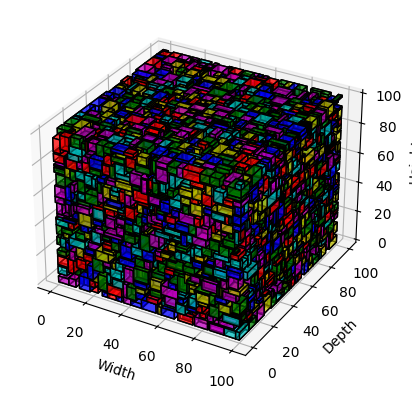

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.stats as stats
import random

class CargoStorage:
    def __init__(self, width=100, depth=100, height=100):
        self.width = width
        self.depth = depth
        self.height = height
        self.items = []  # List of stored items
        self.occupied_space = np.zeros((width, depth, height))

    def add_item(self, item):
        for position in self._generate_positions(item):
            if self._fits(item, position):
                self._store_item(item, position)
                return f"Item {item['Item ID']} placed at {position}"
        return f"No space for item {item['Item ID']}"

    def _generate_positions(self, item):
        # Using Gaussian distribution to prefer central placement
        x_positions = np.clip(np.random.normal(self.width // 2, self.width // 4, 1000).astype(int), 0, self.width - item['Width'])
        y_positions = np.clip(np.random.normal(self.depth // 2, self.depth // 4, 1000).astype(int), 0, self.depth - item['Depth'])
        z_positions = np.clip(np.random.normal(self.height // 2, self.height // 4, 1000).astype(int), 0, self.height - item['Height'])

        return zip(x_positions, y_positions, z_positions)

    def _fits(self, item, position):
        x, y, z = position
        return np.sum(self.occupied_space[x:x+item['Width'], y:y+item['Depth'], z:z+item['Height']]) == 0

    def _store_item(self, item, position):
        x, y, z = position
        self.occupied_space[x:x+item['Width'], y:y+item['Depth'], z:z+item['Height']] = 1
        item['Position'] = position
        self.items.append(item)

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']

        for item in self.items:
            x, y, z = item['Position']
            dx, dy, dz = item['Width'], item['Depth'], item['Height']
            color = random.choice(colors)

            verts = [
                [(x, y, z), (x+dx, y, z), (x+dx, y+dy, z), (x, y+dy, z)],
                [(x, y, z+dz), (x+dx, y, z+dz), (x+dx, y+dy, z+dz), (x, y+dy, z+dz)],
                [(x, y, z), (x, y, z+dz), (x, y+dy, z+dz), (x, y+dy, z)],
                [(x+dx, y, z), (x+dx, y, z+dz), (x+dx, y+dy, z+dz), (x+dx, y+dy, z)],
                [(x, y, z), (x+dx, y, z), (x+dx, y, z+dz), (x, y, z+dz)],
                [(x, y+dy, z), (x+dx, y+dy, z), (x+dx, y+dy, z+dz), (x, y+dy, z+dz)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

# Generate items with normal distributions
num_items = 10000
items = [
    {'Item ID': str(i).zfill(4), 'Width': max(1, int(np.random.normal(5, 2))), 'Depth': max(1, int(np.random.normal(5, 2))), 'Height': max(1, int(np.random.normal(5, 2))) }
    for i in range(num_items)
]

storage = CargoStorage()
for item in items:
    print(storage.add_item(item))

storage.plot_storage()


In [ ]:
# @title PYMC NOT WORKING
import pymc as pm
import numpy as np
import pandas as pd
import random

class BayesianCargoStorage:
    def __init__(self, width=100, depth=100, height=100):
        self.width = width
        self.depth = depth
        self.height = height
        self.items = []
        self.occupied_space = np.zeros((width, depth, height))

    def bayesian_fit(self, item):
        with pm.Model() as model:
            w = pm.Normal("w", mu=self.width / 2, sigma=self.width / 6)
            d = pm.Normal("d", mu=self.depth / 2, sigma=self.depth / 6)
            h = pm.Normal("h", mu=self.height / 2, sigma=self.height / 6)
            trace = pm.sample(500, tune=500, chains=2, target_accept=0.9, progressbar=False)

        w_pos = int(np.clip(trace.posterior["w"].mean().item(), 0, self.width - item['Width']))
        d_pos = int(np.clip(trace.posterior["d"].mean().item(), 0, self.depth - item['Depth']))
        h_pos = int(np.clip(trace.posterior["h"].mean().item(), 0, self.height - item['Height']))
        return (w_pos, d_pos, h_pos)

    def add_item(self, item):
        position = self.bayesian_fit(item)
        if self._check_space(position, item):
            self._store_item(item, position)
            return f"Item {item['Item ID']} placed at {position}"
        return "No space left for this item."

    def _check_space(self, position, item):
        w, d, h = position
        if np.sum(self.occupied_space[w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']]) == 0:
            return True
        return False

    def _store_item(self, item, position):
        item['Position'] = position
        self.items.append(item)
        w, d, h = position
        self.occupied_space[w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']] = 1

# Example items
test_items = [
    {'Item ID': str(i).zfill(3), 'Width': random.randint(5, 15), 'Depth': random.randint(5, 15), 'Height': random.randint(5, 15)}
    for i in range(1, 51)
]

storage = BayesianCargoStorage()
for item in test_items:
    print(storage.add_item(item))


Item 001 placed at (49, 50, 50)
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space left for this item.
No space le

In [ ]:
# @title Endless error due to zone expansion {"vertical-output":true}
import numpy as np
import random
from collections import defaultdict

class ZoneStorage:
    def __init__(self, width=100, depth=100, height=100, zones=5):
        self.width = width
        self.depth = depth
        self.height = height
        self.zones = {i: np.zeros((width // zones, depth, height)) for i in range(1, zones + 1)}
        self.cargo_locations = {}
        self.unstored_cargo = defaultdict(list)

    def add_cargo(self, cargo_id, width, depth, height, priority, preferred_zone):
        sorted_zones = sorted(self.zones.keys(), key=lambda z: (z != preferred_zone, z))  # Prefer user-selected zone
        for zone in sorted_zones:
            position = self._find_space(zone, width, depth, height)
            if position:
                self._store_cargo(zone, cargo_id, position, width, depth, height)
                return f"Cargo {cargo_id} stored in Zone {zone} from {position} to {(position[0] + width, position[1] + depth, position[2] + height)}"

        self.unstored_cargo[preferred_zone].append((cargo_id, width, depth, height, priority))
        return f"No space in Zone {preferred_zone} for Cargo {cargo_id}. Moved to unstored list."

    def _find_space(self, zone, width, depth, height):
        grid = self.zones[zone]
        for x in range(grid.shape[0] - width + 1):
            for y in range(grid.shape[1] - depth + 1):
                for z in range(grid.shape[2] - height + 1):
                    if np.sum(grid[x:x+width, y:y+depth, z:z+height]) == 0:
                        return (x, y, z)
        return None

    def _store_cargo(self, zone, cargo_id, position, width, depth, height):
        self.cargo_locations[cargo_id] = (zone, position, (position[0] + width, position[1] + depth, position[2] + height))
        x, y, z = position
        self.zones[zone][x:x+width, y:y+depth, z:z+height] = 1

    def expand_zone(self):
        if not self.unstored_cargo:
            return "All zones are utilized efficiently."

        max_unstored_zone = max(self.unstored_cargo, key=lambda z: len(self.unstored_cargo[z]))
        expanded_zone = random.choice([z for z in self.zones if z != max_unstored_zone])
        self.zones[max_unstored_zone] = np.zeros((self.width // self.zones, self.depth, self.height))

        for cargo in sorted(self.unstored_cargo[max_unstored_zone], key=lambda x: x[4], reverse=True):
            cargo_id, width, depth, height, _ = cargo
            self.add_cargo(cargo_id, width, depth, height, priority, max_unstored_zone)

        return f"Expanded Zone {max_unstored_zone} to store remaining cargo."

    def get_cargo_location(self, cargo_id):
        return self.cargo_locations.get(cargo_id, "Cargo not found.")

# Example Usage
storage = ZoneStorage()
cargo_items = [(f"C{i}", random.randint(5, 20), random.randint(5, 20), random.randint(5, 20), random.randint(1, 100), random.randint(1, 5)) for i in range(10000)]

for cargo in sorted(cargo_items, key=lambda x: x[4], reverse=True):
    print(storage.add_cargo(*cargo))

print(storage.expand_zone())


Cargo C74 stored in Zone 5 from (0, 0, 0) to (8, 20, 14)
Cargo C226 stored in Zone 2 from (0, 0, 0) to (9, 17, 8)
Cargo C458 stored in Zone 2 from (0, 0, 8) to (16, 5, 17)
Cargo C465 stored in Zone 4 from (0, 0, 0) to (11, 20, 7)
Cargo C744 stored in Zone 2 from (0, 0, 17) to (12, 9, 24)
Cargo C914 stored in Zone 3 from (0, 0, 0) to (8, 11, 11)
Cargo C1039 stored in Zone 3 from (0, 0, 11) to (19, 6, 30)
Cargo C1140 stored in Zone 4 from (0, 0, 7) to (17, 6, 25)
Cargo C1250 stored in Zone 1 from (0, 0, 0) to (9, 19, 17)
Cargo C1326 stored in Zone 1 from (0, 0, 17) to (19, 15, 27)
Cargo C1545 stored in Zone 1 from (0, 0, 27) to (13, 16, 45)
Cargo C1775 stored in Zone 2 from (0, 0, 24) to (11, 11, 31)
Cargo C2009 stored in Zone 1 from (0, 0, 45) to (12, 18, 62)
Cargo C2158 stored in Zone 5 from (0, 0, 14) to (8, 18, 25)
Cargo C2254 stored in Zone 4 from (0, 0, 25) to (7, 20, 30)
Cargo C2280 stored in Zone 4 from (0, 0, 30) to (7, 16, 42)
Cargo C2341 stored in Zone 4 from (0, 0, 42) to (19

KeyboardInterrupt: 

In [ ]:
# @title Too Slow {"vertical-output":true}
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random

class CargoStorage:
    def __init__(self, storage_dimensions, zones):
        self.storage_dimensions = storage_dimensions  # Overall storage size (Width, Depth, Height)
        self.zones = zones  # Zone definitions
        self.items = []  # List of stored items
        self.occupied_spaces = {zone: np.zeros(storage_dimensions) for zone in zones}

    def add_item(self, item, preferred_zone):
        if preferred_zone not in self.zones:
            return f"Invalid zone selection for {item['Item ID']}"

        for attempt in range(2):  # Try twice before rejecting
            position = self._find_best_position(item, preferred_zone)
            if position:
                self._store_item(item, preferred_zone, position)
                start_pos = position
                end_pos = (position[0] + item['Width'] - 1, position[1] + item['Depth'] - 1, position[2] + item['Height'] - 1)
                return f"Item {item['Item ID']} placed in {preferred_zone} from {start_pos} to {end_pos}"

        return f"No space available for item {item['Item ID']} in {preferred_zone}"

    def _find_best_position(self, item, zone):
        occupied = self.occupied_spaces[zone]
        for w in range(self.storage_dimensions[0] - item['Width'] + 1):
            for d in range(self.storage_dimensions[1] - item['Depth'] + 1):
                for h in range(self.storage_dimensions[2] - item['Height'] + 1):
                    if np.sum(occupied[w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']]) == 0:
                        return (w, d, h)
        return None

    def _store_item(self, item, zone, position):
        item['Zone'] = zone
        item['Position'] = position
        self.items.append(item)
        w, d, h = position
        self.occupied_spaces[zone][w:w+item['Width'], d:d+item['Depth'], h:h+item['Height']] = 1

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c']
        zone_colors = {zone: colors[i] for i, zone in enumerate(self.zones)}

        for item in self.items:
            w, d, h = item['Position']
            x_size, y_size, z_size = item['Width'], item['Depth'], item['Height']
            color = zone_colors[item['Zone']]

            verts = [
                [(w, d, h), (w + x_size, d, h), (w + x_size, d + y_size, h), (w, d + y_size, h)],
                [(w, d, h + z_size), (w + x_size, d, h + z_size), (w + x_size, d + y_size, h + z_size), (w, d + y_size, h + z_size)],
                [(w, d, h), (w, d, h + z_size), (w, d + y_size, h + z_size), (w, d + y_size, h)],
                [(w + x_size, d, h), (w + x_size, d, h + z_size), (w + x_size, d + y_size, h + z_size), (w + x_size, d + y_size, h)],
                [(w, d, h), (w + x_size, d, h), (w + x_size, d, h + z_size), (w, d, h + z_size)],
                [(w, d + y_size, h), (w + x_size, d + y_size, h), (w + x_size, d + y_size, h + z_size), (w, d + y_size, h + z_size)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

# Example setup
zones = ['Zone A', 'Zone B', 'Zone C', 'Zone D', 'Zone E']
storage = CargoStorage(storage_dimensions=(100, 100, 100), zones=zones)

# Generate 10,000 random items
items = [
    {'Item ID': str(i).zfill(5), 'Name': f'Item {i}', 'Width': random.randint(1, 10), 'Depth': random.randint(1, 10), 'Height': random.randint(1, 10), 'Mass': random.randint(1, 50), 'Priority': random.randint(50, 100)}
    for i in range(1, 10001)
]

# Assign preferred zones and store
for item in items:
    preferred_zone = random.choice(zones)
    print(storage.add_item(item, preferred_zone))

# Plot overall storage
storage.plot_storage()


Item 00001 placed in Zone B from (0, 0, 0) to (0, 3, 3)
Item 00002 placed in Zone E from (0, 0, 0) to (5, 3, 3)
Item 00003 placed in Zone C from (0, 0, 0) to (6, 5, 9)
Item 00004 placed in Zone D from (0, 0, 0) to (7, 8, 1)
Item 00005 placed in Zone C from (0, 0, 10) to (1, 5, 17)
Item 00006 placed in Zone D from (0, 0, 2) to (8, 5, 2)
Item 00007 placed in Zone C from (0, 0, 18) to (0, 2, 20)
Item 00008 placed in Zone D from (0, 0, 3) to (8, 7, 4)
Item 00009 placed in Zone A from (0, 0, 0) to (3, 7, 2)
Item 00010 placed in Zone A from (0, 0, 3) to (7, 4, 7)
Item 00011 placed in Zone A from (0, 0, 8) to (7, 1, 17)
Item 00012 placed in Zone D from (0, 0, 5) to (8, 6, 11)
Item 00013 placed in Zone A from (0, 0, 18) to (2, 2, 25)
Item 00014 placed in Zone B from (0, 0, 4) to (3, 1, 13)
Item 00015 placed in Zone A from (0, 0, 26) to (7, 1, 33)
Item 00016 placed in Zone D from (0, 0, 12) to (1, 2, 13)
Item 00017 placed in Zone B from (0, 0, 14) to (0, 3, 18)
Item 00018 placed in Zone C from 

KeyboardInterrupt: 

In [ ]:
!pip install rtree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
from rtree import index
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random

class CargoStorageRTree:
    def __init__(self, width, depth, height):
        self.width = width
        self.depth = depth
        self.height = height
        self.items = []
        # Create a 3D index using the 'index.Property'
        p = index.Property()
        p.dimension = 3
        self.rtree = index.Index(properties=p)
        self.id_counter = 0

    def add_item(self, item):
        w, d, h = item['Width'], item['Depth'], item['Height']

        for _ in range(2):  # Try twice before rejecting
            position = self.find_space(w, d, h)
            if position:
                self.store_item(item, position)
                return position
        return None

    def find_space(self, w, d, h):
        for _ in range(10000):  # Randomized search for placement
            x, y, z = random.randint(0, self.width - w), random.randint(0, self.depth - d), random.randint(0, self.height - h)
            if self.is_space_free(x, y, z, w, d, h):
                return (x, y, z)
        return None

    def is_space_free(self, x, y, z, w, d, h):
        bbox = (x, y, z, x + w, y + d, z + h)
        if list(self.rtree.intersection(bbox)):
            return False
        return True

    def store_item(self, item, position):
        x, y, z = position
        bbox = (x, y, z, x + item['Width'], y + item['Depth'], z + item['Height'])
        self.rtree.insert(self.id_counter, bbox)
        item['Position'] = position
        self.items.append(item)
        self.id_counter += 1

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']

        for i, item in enumerate(self.items):
            x, y, z = item['Position']
            w, d, h = item['Width'], item['Depth'], item['Height']
            color = colors[i % len(colors)]
            verts = [
                [(x, y, z), (x + w, y, z), (x + w, y + d, z), (x, y + d, z)],
                [(x, y, z + h), (x + w, y, z + h), (x + w, y + d, z + h), (x, y + d, z + h)],
                [(x, y, z), (x, y, z + h), (x, y + d, z + h), (x, y + d, z)],
                [(x + w, y, z), (x + w, y, z + h), (x + w, y + d, z + h), (x + w, y + d, z)],
                [(x, y, z), (x + w, y, z), (x + w, y, z + h), (x, y, z + h)],
                [(x, y + d, z), (x + w, y + d, z), (x + w, y + d, z + h), (x, y + d, z + h)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

# Initialize storage space
storage_rtree = CargoStorageRTree(100, 100, 100)

# Generate cargo items
items = [
    {'Item ID': str(i), 'Width': random.randint(5, 20), 'Depth': random.randint(5, 20), 'Height': random.randint(5, 20)}
    for i in range(1000)
]

# Store items
for item in items:
    storage_rtree.add_item(item)

# Plot final storage layout
storage_rtree.plot_storage()


KeyboardInterrupt: 

Streaming output truncated to the last 5000 lines.
Item 5000 placed from (23, 10, 28) to (31, 20, 33)
Item 5001 placed from (3, 9, 3) to (13, 19, 9)
Item 5002 placed from (54, 11, 33) to (63, 16, 43)
Item 5003 placed from (47, 5, 13) to (55, 13, 19)
Item 5004 placed from (15, 20, 9) to (24, 29, 14)
Item 5005 placed from (24, 17, 29) to (33, 23, 39)
Item 5006 placed from (1, 14, 2) to (6, 22, 7)
Item 5007 placed from (19, 12, 5) to (28, 21, 15)
Item 5008 placed from (17, 30, 37) to (27, 38, 43)
Item 5009 placed from (37, 4, 19) to (42, 9, 28)
Item 5010 placed from (13, 22, 39) to (20, 31, 47)
Item 5011 placed from (19, 42, 20) to (28, 52, 26)
Item 5012 placed from (29, 10, 9) to (36, 20, 17)
Item 5013 placed from (19, 33, 42) to (24, 42, 48)
Item 5014 placed from (16, 10, 19) to (22, 15, 27)
Item 5015 placed from (25, 9, 31) to (34, 17, 41)
Item 5016 placed from (27, 15, 26) to (36, 25, 32)
Item 5017 placed from (31, 6, 10) to (36, 12, 20)
Item 5018 placed from (18, 8, 11) to (26, 17, 1

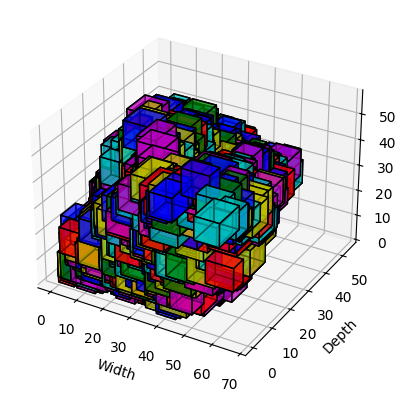

In [ ]:
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random

class CargoStorageKDTree:
    def __init__(self, width, depth, height):
        self.width = width
        self.depth = depth
        self.height = height
        self.items = []
        self.kd_tree = None

    def add_item(self, item):
        for _ in range(2):  # Check twice before failing
            position = self._find_best_position(item)
            if position:
                self._store_item(item, position)
                return f"Item {item['Item ID']} placed from {position} to {(position[0] + item['Width'], position[1] + item['Depth'], position[2] + item['Height'])}"
        return f"No space available for Item {item['Item ID']}"

    def _find_best_position(self, item):
        if not self.items:
            return (0, 0, 0)

        candidate_positions = [(random.randint(0, self.width - item['Width']),
                                random.randint(0, self.depth - item['Depth']),
                                random.randint(0, self.height - item['Height']))
                               for _ in range(100)]

        if self.kd_tree:
            distances, _ = self.kd_tree.query(candidate_positions)
            best_index = np.argmin(distances)
            return candidate_positions[best_index]
        else:
            return candidate_positions[0]

    def _store_item(self, item, position):
        item['Position'] = position
        self.items.append(item)

        points = np.array([item['Position'] for item in self.items])
        self.kd_tree = KDTree(points)

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']
        color_idx = 0

        for item in self.items:
            x, y, z = item['Position']
            x_size, y_size, z_size = item['Width'], item['Depth'], item['Height']
            color = colors[color_idx % len(colors)]
            color_idx += 1

            verts = [
                [(x, y, z), (x + x_size, y, z), (x + x_size, y + y_size, z), (x, y + y_size, z)],
                [(x, y, z + z_size), (x + x_size, y, z + z_size), (x + x_size, y + y_size, z + z_size), (x, y + y_size, z + z_size)],
                [(x, y, z), (x, y, z + z_size), (x, y + y_size, z + z_size), (x, y + y_size, z)],
                [(x + x_size, y, z), (x + x_size, y, z + z_size), (x + x_size, y + y_size, z + z_size), (x + x_size, y + y_size, z)],
                [(x, y, z), (x + x_size, y, z), (x + x_size, y, z + z_size), (x, y, z + z_size)],
                [(x, y + y_size, z), (x + x_size, y + y_size, z), (x + x_size, y + y_size, z + z_size), (x, y + y_size, z + z_size)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

# Example test
storage_kdtree = CargoStorageKDTree(100, 100, 100)

items = [
    {'Item ID': str(i), 'Width': random.randint(5, 10), 'Depth': random.randint(5, 10), 'Height': random.randint(5, 10)}
    for i in range(10000)
]

for item in items:
    print(storage_kdtree.add_item(item))

storage_kdtree.plot_storage()


Item 0 placed from (0, 0, 0) to (9, 7, 8)
Item 1 placed from (0, 0, 4) to (8, 7, 13)
Item 2 placed from (0, 0, 10) to (10, 8, 17)
Item 3 placed from (0, 0, 13) to (6, 6, 21)
Item 4 placed from (0, 0, 19) to (8, 10, 24)
Item 5 placed from (0, 0, 22) to (8, 6, 28)
Item 6 placed from (0, 0, 28) to (10, 9, 33)
Item 7 placed from (0, 0, 32) to (8, 10, 39)
Item 8 placed from (0, 0, 25) to (5, 6, 32)
Item 9 placed from (0, 0, 37) to (7, 8, 43)
Item 10 placed from (0, 0, 42) to (10, 9, 48)
Item 11 placed from (0, 0, 47) to (9, 8, 52)
Item 12 placed from (0, 0, 50) to (7, 9, 59)
Item 13 placed from (0, 0, 56) to (7, 10, 63)
Item 14 placed from (0, 0, 60) to (5, 10, 70)
Item 15 placed from (0, 0, 67) to (9, 8, 72)
Item 16 placed from (0, 0, 70) to (7, 9, 79)
Item 17 placed from (0, 0, 75) to (9, 8, 85)
Item 18 placed from (0, 0, 80) to (7, 5, 88)
Item 19 placed from (0, 0, 86) to (7, 10, 91)
Item 20 placed from (0, 0, 90) to (6, 8, 95)
Item 21 placed from (0, 3, 2) to (10, 13, 11)
Item 22 placed

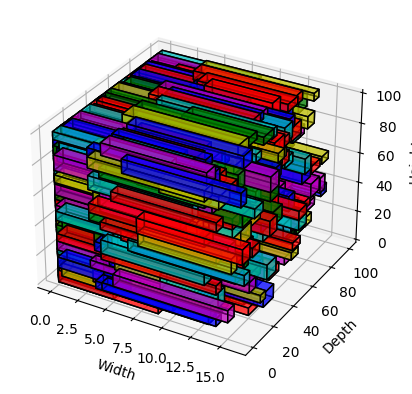

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random

class CargoStorageKDTree:
    def __init__(self, width, depth, height):
        self.width = width
        self.depth = depth
        self.height = height
        self.items = []
        self.kdtree = None

    def add_item(self, item):
        for _ in range(2):  # Check twice before failing
            position = self._find_best_position(item)
            if position:
                self._store_item(item, position)
                return f"Item {item['Item ID']} placed from {position} to {(position[0] + item['Width'], position[1] + item['Depth'], position[2] + item['Height'])}"
        return f"No space available for Item {item['Item ID']}"

    def _find_best_position(self, item):
        for x in range(self.width - item['Width'] + 1):
            for y in range(self.depth - item['Depth'] + 1):
                for z in range(self.height - item['Height'] + 1):
                    if not self._check_overlap((x, y, z), item):
                        return (x, y, z)
        return None

    def _check_overlap(self, position, item):
        if self.kdtree is None:
            return False

        x, y, z = position
        w, d, h = item['Width'], item['Depth'], item['Height']
        center = (x + w / 2, y + d / 2, z + h / 2)
        max_dim = max(w, d, h) / 2
        indices = self.kdtree.query_ball_point(center, max_dim)

        for idx in indices:
            existing_item = self.items[idx]
            ex, ey, ez = existing_item['Position']
            ew, ed, eh = existing_item['Width'], existing_item['Depth'], existing_item['Height']

            overlap_x = (x < ex + ew) and (x + w > ex)
            overlap_y = (y < ey + ed) and (y + d > ey)
            overlap_z = (z < ez + eh) and (z + h > ez)

            if overlap_x and overlap_y and overlap_z:
                return True
        return False

    def _store_item(self, item, position):
        item['Position'] = position
        self.items.append(item)
        points = [(itm['Position'][0] + itm['Width'] / 2, itm['Position'][1] + itm['Depth'] / 2, itm['Position'][2] + itm['Height'] / 2) for itm in self.items]
        self.kdtree = KDTree(points)

    def save_to_csv(self, filename):
        data = [{
            'Item ID': item['Item ID'],
            'Start X': item['Position'][0],
            'Start Y': item['Position'][1],
            'Start Z': item['Position'][2],
            'End X': item['Position'][0] + item['Width'],
            'End Y': item['Position'][1] + item['Depth'],
            'End Z': item['Position'][2] + item['Height'],
            'Width': item['Width'],
            'Depth': item['Depth'],
            'Height': item['Height']
        } for item in self.items]
        df = pd.DataFrame(data)
        df.to_csv(filename, index=False)

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']
        color_idx = 0

        for item in self.items:
            x, y, z = item['Position']
            x_size, y_size, z_size = item['Width'], item['Depth'], item['Height']
            color = colors[color_idx % len(colors)]
            color_idx += 1

            verts = [
                [(x, y, z), (x + x_size, y, z), (x + x_size, y + y_size, z), (x, y + y_size, z)],
                [(x, y, z + z_size), (x + x_size, y, z + z_size), (x + x_size, y + y_size, z + z_size), (x, y + y_size, z + z_size)],
                [(x, y, z), (x, y, z + z_size), (x, y + y_size, z + z_size), (x, y + y_size, z)],
                [(x + x_size, y, z), (x + x_size, y, z + z_size), (x + x_size, y + y_size, z + z_size), (x + x_size, y + y_size, z)],
                [(x, y, z), (x + x_size, y, z), (x + x_size, y, z + z_size), (x, y, z + z_size)],
                [(x, y + y_size, z), (x + x_size, y + y_size, z), (x + x_size, y + y_size, z + z_size), (x, y + y_size, z + z_size)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

# Example test
storage_kdtree = CargoStorageKDTree(100, 100, 100)

items = [
    {'Item ID': str(i), 'Width': random.randint(5, 10), 'Depth': random.randint(5, 10), 'Height': random.randint(5, 10)}
    for i in range(1000)
]

for item in items:
    print(storage_kdtree.add_item(item))

storage_kdtree.save_to_csv("cargo_storage.csv")
storage_kdtree.plot_storage()

No space available for Item 0 in Zone E
Item 1 placed in Zone C from (4, 0, 0) to (10, 7, 8)
Item 2 placed in Zone C from (4, 3, 3) to (9, 10, 10)
No space available for Item 3 in Zone A
No space available for Item 4 in Zone E
No space available for Item 5 in Zone D
No space available for Item 6 in Zone E
No space available for Item 7 in Zone E
No space available for Item 8 in Zone B
No space available for Item 9 in Zone B
No space available for Item 10 in Zone A
No space available for Item 11 in Zone E
No space available for Item 12 in Zone B
No space available for Item 13 in Zone B
No space available for Item 14 in Zone D
No space available for Item 15 in Zone D
No space available for Item 16 in Zone D
No space available for Item 17 in Zone C
Item 18 placed in Zone A from (0, 2, 0) to (7, 10, 6)
No space available for Item 19 in Zone C
No space available for Item 20 in Zone D
No space available for Item 21 in Zone D
No space available for Item 22 in Zone A
No space available for Item

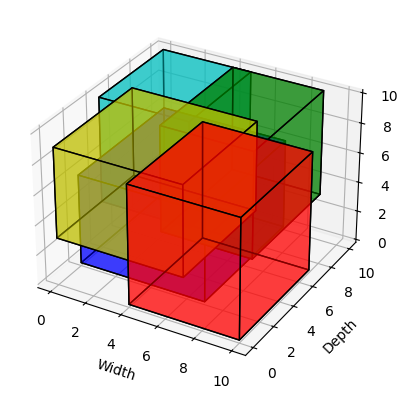

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random

class CargoStorageKDTree:
    def __init__(self, width, depth, height):
        self.width = width
        self.depth = depth
        self.height = height
        self.items = []
        self.kdtree = None
        self.zones = {
            "A": (0, width//5),
            "B": (width//5, 2*width//5),
            "C": (2*width//5, 3*width//5),
            "D": (3*width//5, 4*width//5),
            "E": (4*width//5, width)
        }

    def add_item(self, item, preferred_zone=None):
        if preferred_zone and preferred_zone in self.zones:
            zone_range = self.zones[preferred_zone]
        else:
            zone_range = (0, self.width)

        for _ in range(2):  # Check twice before failing
            position = self._find_best_position(item, zone_range)
            if position:
                self._store_item(item, position, preferred_zone)
                return f"Item {item['Item ID']} placed in Zone {preferred_zone} from {position} to {(position[0] + item['Width'], position[1] + item['Depth'], position[2] + item['Height'])}"
        return f"No space available for Item {item['Item ID']} in Zone {preferred_zone}"

    def _find_best_position(self, item, zone_range):
        for x in range(zone_range[0], min(zone_range[1], self.width - item['Width'] + 1)):
            for y in range(self.depth - item['Depth'] + 1):
                for z in range(self.height - item['Height'] + 1):
                    if not self._check_overlap((x, y, z), item):
                        return (x, y, z)
        return None

    def _check_overlap(self, position, item):
        if self.kdtree is None:
            return False

        x, y, z = position
        w, d, h = item['Width'], item['Depth'], item['Height']
        center = (x + w / 2, y + d / 2, z + h / 2)
        max_dim = max(w, d, h) / 2
        indices = self.kdtree.query_ball_point(center, max_dim)

        for idx in indices:
            existing_item = self.items[idx]
            ex, ey, ez = existing_item['Position']
            ew, ed, eh = existing_item['Width'], existing_item['Depth'], existing_item['Height']

            overlap_x = (x < ex + ew) and (x + w > ex)
            overlap_y = (y < ey + ed) and (y + d > ey)
            overlap_z = (z < ez + eh) and (z + h > ez)

            if overlap_x and overlap_y and overlap_z:
                return True
        return False

    def _store_item(self, item, position, zone):
        item['Position'] = position
        item['Zone'] = zone
        self.items.append(item)
        points = [(itm['Position'][0] + itm['Width'] / 2, itm['Position'][1] + itm['Depth'] / 2, itm['Position'][2] + itm['Height'] / 2) for itm in self.items]
        self.kdtree = KDTree(points)

    def save_to_csv(self, filename):
        data = [{
            'Item ID': item['Item ID'],
            'Start X': item['Position'][0],
            'Start Y': item['Position'][1],
            'Start Z': item['Position'][2],
            'End X': item['Position'][0] + item['Width'],
            'End Y': item['Position'][1] + item['Depth'],
            'End Z': item['Position'][2] + item['Height'],
            'Width': item['Width'],
            'Depth': item['Depth'],
            'Height': item['Height'],
            'Zone': item['Zone']
        } for item in self.items]
        df = pd.DataFrame(data)
        df.to_csv(filename, index=False)

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']
        color_idx = 0

        for item in self.items:
            x, y, z = item['Position']
            x_size, y_size, z_size = item['Width'], item['Depth'], item['Height']
            color = colors[color_idx % len(colors)]
            color_idx += 1

            verts = [
                [(x, y, z), (x + x_size, y, z), (x + x_size, y + y_size, z), (x, y + y_size, z)],
                [(x, y, z + z_size), (x + x_size, y, z + z_size), (x + x_size, y + y_size, z + z_size), (x, y + y_size, z + z_size)],
                [(x, y, z), (x, y, z + z_size), (x, y + y_size, z + z_size), (x, y + y_size, z)],
                [(x + x_size, y, z), (x + x_size, y, z + z_size), (x + x_size, y + y_size, z + z_size), (x + x_size, y + y_size, z)],
                [(x, y, z), (x + x_size, y, z), (x + x_size, y, z + z_size), (x, y, z + z_size)],
                [(x, y + y_size, z), (x + x_size, y + y_size, z), (x + x_size, y + y_size, z + z_size), (x, y + y_size, z + z_size)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

# Example test
storage_kdtree = CargoStorageKDTree(10, 10, 10)

zones = ["A", "B", "C", "D", "E"]
items = [
    {'Item ID': str(i), 'Width': random.randint(5, 10), 'Depth': random.randint(5, 10), 'Height': random.randint(5, 10)}
    for i in range(100)
]

for item in items:
    preferred_zone = random.choice(zones)
    print(storage_kdtree.add_item(item, preferred_zone))

storage_kdtree.save_to_csv("cargo_storage.csv")
storage_kdtree.plot_storage()


Item 0 placed in Zone B from (10, 0, 0) to (11, 6, 8)
Item 1 placed in Zone E from (40, 0, 0) to (42, 19, 12)
Item 2 placed in Zone D from (30, 0, 0) to (32, 11, 8)
Item 3 placed in Zone E from (40, 0, 9) to (42, 15, 18)
Item 4 placed in Zone A from (0, 0, 0) to (10, 16, 8)
Item 5 placed in Zone C from (20, 0, 0) to (30, 5, 7)
Item 6 placed in Zone B from (10, 0, 6) to (14, 19, 17)
Item 7 placed in Zone C from (20, 0, 6) to (29, 13, 13)
Item 8 placed in Zone A from (0, 0, 4) to (10, 10, 13)
Item 9 placed in Zone C from (20, 0, 13) to (27, 17, 19)
Item 10 placed in Zone B from (10, 0, 16) to (12, 17, 25)
Item 11 placed in Zone E from (40, 0, 14) to (44, 11, 26)
Item 12 placed in Zone C from (20, 0, 13) to (28, 7, 24)
Item 13 placed in Zone A from (0, 0, 13) to (9, 14, 19)
Item 14 placed in Zone B from (10, 0, 10) to (18, 11, 22)
Item 15 placed in Zone E from (40, 0, 0) to (46, 7, 11)
Item 16 placed in Zone E from (40, 0, 6) to (45, 8, 14)
Item 17 placed in Zone D from (30, 0, 4) to (31,

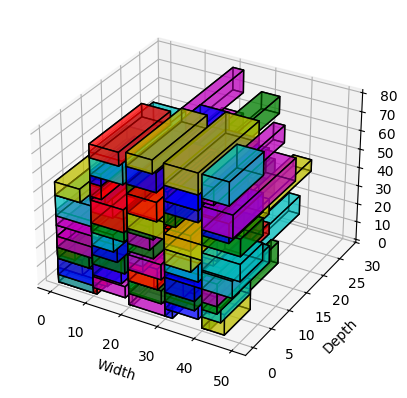

Unstored Items: []


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random

class CargoStorageKDTree:
    def __init__(self, width, depth, height):
        self.width = width
        self.depth = depth
        self.height = height
        self.items = []
        self.kdtree = None
        self.unstored_items = []
        self.zones = {
            "A": (0, width//5),
            "B": (width//5, 2*width//5),
            "C": (2*width//5, 3*width//5),
            "D": (3*width//5, 4*width//5),
            "E": (4*width//5, width)
        }

    def add_item(self, item, preferred_zone=None):
        if preferred_zone and preferred_zone in self.zones:
            zone_range = self.zones[preferred_zone]
        else:
            zone_range = (0, self.width)

        position = self._find_best_position(item, zone_range)
        if position:
            self._store_item(item, position, preferred_zone)
            return f"Item {item['Item ID']} placed in Zone {preferred_zone} from {position} to {(position[0] + item['Width'], position[1] + item['Depth'], position[2] + item['Height'])}"

        self.unstored_items.append(item)
        return f"No space available for Item {item['Item ID']} in Zone {preferred_zone}"

    def _find_best_position(self, item, zone_range):
        for x in range(zone_range[0], min(zone_range[1], self.width - item['Width'] + 1)):
            for y in range(self.depth - item['Depth'] + 1):
                for z in range(self.height - item['Height'] + 1):
                    if not self._check_overlap((x, y, z), item):
                        return (x, y, z)
        return None

    def _check_overlap(self, position, item):
        if self.kdtree is None:
            return False

        x, y, z = position
        w, d, h = item['Width'], item['Depth'], item['Height']
        center = (x + w / 2, y + d / 2, z + h / 2)
        max_dim = max(w, d, h) / 2
        indices = self.kdtree.query_ball_point(center, max_dim)

        for idx in indices:
            existing_item = self.items[idx]
            ex, ey, ez = existing_item['Position']
            ew, ed, eh = existing_item['Width'], existing_item['Depth'], existing_item['Height']

            overlap_x = (x < ex + ew) and (x + w > ex)
            overlap_y = (y < ey + ed) and (y + d > ey)
            overlap_z = (z < ez + eh) and (z + h > ez)

            if overlap_x and overlap_y and overlap_z:
                return True
        return False

    def _store_item(self, item, position, zone):
        item['Position'] = position
        item['Zone'] = zone
        self.items.append(item)
        points = [(itm['Position'][0] + itm['Width'] / 2, itm['Position'][1] + itm['Depth'] / 2, itm['Position'][2] + itm['Height'] / 2) for itm in self.items]
        self.kdtree = KDTree(points)

    def save_to_csv(self, filename):
        data = [{
            'Item ID': item['Item ID'],
            'Start X': item['Position'][0],
            'Start Y': item['Position'][1],
            'Start Z': item['Position'][2],
            'End X': item['Position'][0] + item['Width'],
            'End Y': item['Position'][1] + item['Depth'],
            'End Z': item['Position'][2] + item['Height'],
            'Width': item['Width'],
            'Depth': item['Depth'],
            'Height': item['Height'],
            'Zone': item['Zone']
        } for item in self.items]
        df = pd.DataFrame(data)
        df.to_csv(filename, index=False)

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']
        color_idx = 0

        for item in self.items:
            x, y, z = item['Position']
            x_size, y_size, z_size = item['Width'], item['Depth'], item['Height']
            color = colors[color_idx % len(colors)]
            color_idx += 1

            verts = [
                [(x, y, z), (x + x_size, y, z), (x + x_size, y + y_size, z), (x, y + y_size, z)],
                [(x, y, z + z_size), (x + x_size, y, z + z_size), (x + x_size, y + y_size, z + z_size), (x, y + y_size, z + z_size)],
                [(x, y, z), (x, y, z + z_size), (x, y + y_size, z + z_size), (x, y + y_size, z)],
                [(x + x_size, y, z), (x + x_size, y, z + z_size), (x + x_size, y + y_size, z + z_size), (x + x_size, y + y_size, z)],
                [(x, y, z), (x + x_size, y, z), (x + x_size, y, z + z_size), (x, y, z + z_size)],
                [(x, y + y_size, z), (x + x_size, y + y_size, z), (x + x_size, y + y_size, z + z_size), (x, y + y_size, z + z_size)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

        print("Unstored Items:", self.unstored_items)

# Example test
storage_kdtree = CargoStorageKDTree(50, 100, 80)

zones = ["A", "B", "C", "D", "E"]
items = [
    {'Item ID': str(i), 'Width': random.randint(1, 10), 'Depth': random.randint(5, 20), 'Height': random.randint(6, 12)}
    for i in range(100)
]

for item in items:
    preferred_zone = random.choice(zones)
    print(storage_kdtree.add_item(item, preferred_zone))

storage_kdtree.save_to_csv("cargo_storage.csv")
storage_kdtree.plot_storage()


Item 0 placed in Zone B from (20, 0, 0) to (29, 6, 6)
Item 1 placed in Zone E from (80, 0, 0) to (85, 10, 9)
Item 2 placed in Zone B from (20, 0, 1) to (30, 8, 8)
Item 3 placed in Zone C from (40, 0, 0) to (45, 8, 8)
Item 4 placed in Zone C from (40, 0, 1) to (46, 7, 9)
Item 5 placed in Zone D from (60, 0, 0) to (65, 5, 5)
Item 6 placed in Zone B from (20, 0, 2) to (29, 9, 12)
Item 7 placed in Zone D from (60, 0, 1) to (66, 6, 7)
Item 8 placed in Zone C from (40, 0, 2) to (49, 10, 12)
Item 9 placed in Zone B from (20, 0, 3) to (30, 9, 13)
Item 10 placed in Zone E from (80, 0, 1) to (87, 8, 6)
Item 11 placed in Zone A from (0, 0, 0) to (7, 6, 7)
Item 12 placed in Zone B from (20, 0, 4) to (25, 7, 10)
Item 13 placed in Zone A from (0, 0, 1) to (10, 8, 10)
Item 14 placed in Zone C from (40, 0, 3) to (50, 7, 9)
Item 15 placed in Zone C from (40, 0, 4) to (48, 7, 11)
Item 16 placed in Zone E from (80, 0, 2) to (90, 7, 11)
Item 17 placed in Zone C from (40, 0, 5) to (45, 8, 10)
Item 18 place

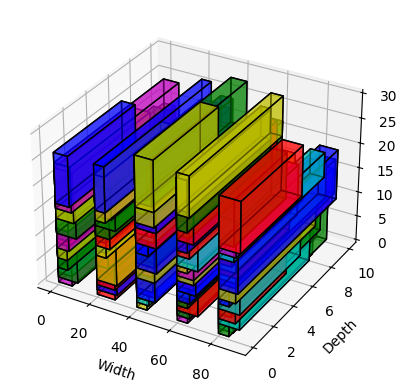

Unstored Items: []


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random

class CargoStorageKDTree:
    def __init__(self, width, depth, height):
        self.width = width
        self.depth = depth
        self.height = height
        self.items = []
        self.kdtree = None
        self.unstored_items = []
        self.zones = {
            "A": (0, width//5),
            "B": (width//5, 2*width//5),
            "C": (2*width//5, 3*width//5),
            "D": (3*width//5, 4*width//5),
            "E": (4*width//5, width)
        }

    def add_item(self, item, preferred_zone=None):
        if preferred_zone and preferred_zone in self.zones:
            zone_range = self.zones[preferred_zone]
        else:
            zone_range = (0, self.width)

        position = self._find_best_position(item, zone_range)
        if position:
            self._store_item(item, position, preferred_zone)
            return f"Item {item['Item ID']} placed in Zone {preferred_zone} from {position} to {(position[0] + item['Width'], position[1] + item['Depth'], position[2] + item['Height'])}"

        self.unstored_items.append(item)
        return f"No space available for Item {item['Item ID']} in Zone {preferred_zone}"

    def _find_best_position(self, item, zone_range):
        for x in range(zone_range[0], min(zone_range[1], self.width - item['Width'] + 1)):
            for y in range(self.depth - item['Depth'] + 1):
                for z in range(self.height - item['Height'] + 1):
                    if not self._check_overlap((x, y, z), item):
                        return (x, y, z)
        return None

    def _check_overlap(self, position, item):
        if self.kdtree is None:
            return False

        x, y, z = position
        w, d, h = item['Width'], item['Depth'], item['Height']
        vertices = [
            (x, y, z), (x + w, y, z), (x, y + d, z), (x, y, z + h),
            (x + w, y + d, z), (x, y + d, z + h), (x + w, y, z + h), (x + w, y + d, z + h)
        ]

        for vertex in vertices:
            indices = self.kdtree.query_ball_point(vertex, 0)
            if indices:
                return True
        return False

    def _store_item(self, item, position, zone):
        item['Position'] = position
        item['Zone'] = zone
        self.items.append(item)
        points = [(itm['Position'][0], itm['Position'][1], itm['Position'][2]) for itm in self.items]
        self.kdtree = KDTree(points)

    def save_to_csv(self, filename):
        data = [{
            'Item ID': item['Item ID'],
            'Start X': item['Position'][0],
            'Start Y': item['Position'][1],
            'Start Z': item['Position'][2],
            'End X': item['Position'][0] + item['Width'],
            'End Y': item['Position'][1] + item['Depth'],
            'End Z': item['Position'][2] + item['Height'],
            'Width': item['Width'],
            'Depth': item['Depth'],
            'Height': item['Height'],
            'Zone': item['Zone']
        } for item in self.items]
        df = pd.DataFrame(data)
        df.to_csv(filename, index=False)

    def plot_storage(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b', 'y', 'c', 'm']
        color_idx = 0

        for item in self.items:
            x, y, z = item['Position']
            x_size, y_size, z_size = item['Width'], item['Depth'], item['Height']
            color = colors[color_idx % len(colors)]
            color_idx += 1

            verts = [
                [(x, y, z), (x + x_size, y, z), (x + x_size, y + y_size, z), (x, y + y_size, z)],
                [(x, y, z + z_size), (x + x_size, y, z + z_size), (x + x_size, y + y_size, z + z_size), (x, y + y_size, z + z_size)],
                [(x, y, z), (x, y, z + z_size), (x, y + y_size, z + z_size), (x, y + y_size, z)],
                [(x + x_size, y, z), (x + x_size, y, z + z_size), (x + x_size, y + y_size, z + z_size), (x + x_size, y + y_size, z)],
                [(x, y, z), (x + x_size, y, z), (x + x_size, y, z + z_size), (x, y, z + z_size)],
                [(x, y + y_size, z), (x + x_size, y + y_size, z), (x + x_size, y + y_size, z + z_size), (x, y + y_size, z + z_size)]
            ]
            ax.add_collection3d(Poly3DCollection(verts, facecolors=color, linewidths=1, edgecolors='k', alpha=0.5))

        ax.set_xlabel('Width')
        ax.set_ylabel('Depth')
        ax.set_zlabel('Height')
        plt.show()

        print("Unstored Items:", self.unstored_items)

# Example test
storage_kdtree = CargoStorageKDTree(100, 100, 100)

zones = ["A", "B", "C", "D", "E"]
items = [
    {'Item ID': str(i), 'Width': random.randint(5, 10), 'Depth': random.randint(5, 10), 'Height': random.randint(5, 10)}
    for i in range(100)
]

for item in items:
    preferred_zone = random.choice(zones)
    print(storage_kdtree.add_item(item, preferred_zone))

storage_kdtree.save_to_csv("cargo_storage.csv")
storage_kdtree.plot_storage()